# Analyzing Vegas Implied Probabilities
Here we will use the Vegas break-even implied probability provided by the moneylines to determine whether is it useful in forecasting the probability a team will win. Inspired by FiveThirtyEight, we will use a **model calibration chart.** 

In a similar vein, we will compare the Vegas results to FTE's models. We will analyze the last 4 NFL seasons to ensure the sample sizes are comparable to FTE. 

We show that betting markets are slightly (around $1\%$) more efficient than FiveThirtyEight's models. 

In [1]:
import datetime
import pandas as pd
import numpy as np
from itertools import product
from scipy import stats
from odds_utils import odds_parser, odds_parser_prob
import matplotlib.pyplot as plt

filename = r'data/nfl odds 2020-21.csv'
# moneyline is for close data only; would have to write a proper web scraper if you wanted to opening line
hold = pd.read_csv(filename)
hold.head()

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,910,451,V,Houston,7,0,0,13,20,54,53.5,375,27
1,910,452,H,KansasCity,0,17,7,10,34,9.5,9.5,-450,3.5
2,913,453,V,Miami,0,3,0,8,11,43,41.5,290,20
3,913,454,H,NewEngland,0,7,7,7,21,7,7,-350,3
4,913,455,V,Cleveland,6,0,0,0,6,48.5,47.5,270,22.5


## Analyzing the data

In [22]:
dfs = []
for fn in [r'data/nfl odds 2017-18.csv',\
           r'data/nfl odds 2018-19.csv',\
           r'data/nfl odds 2019-20.csv',\
           r'data/nfl odds 2020-21.csv']:
    odds = odds_parser(fn)
    odds = odds_parser_prob(odds)
    dfs.append(odds)
odds = pd.concat(dfs).reset_index(drop=True)

In [23]:
odds.iloc[:, -18:]

,OU_Open,OU_Close,OU_2H,Pts_Open,Pts_Close,Pts_2H,Home_Fav,Fav_Team,Dog_Team,ML_Fav,ML_Dog,Prob_Fav,Prob_Dog,Hold,IP_Fav,IP_Dog,Home_Winner,Fav_Winner
0,48.0,47.5,25.5,7.0,8.0,4.5,1.0,NewEngland,KansasCity,-480.0,371.0,0.827586,0.212314,0.039900,0.795832,0.204168,-1,0.0
1,43.0,42.0,21.0,6.0,7.0,5.0,1.0,Buffalo,NYJets,-400.0,317.0,0.800000,0.239808,0.039808,0.769373,0.230627,1,1.0
2,50.5,48.0,24.0,7.0,6.5,4.5,-1.0,Atlanta,Chicago,-319.0,259.0,0.761337,0.278552,0.039888,0.732133,0.267867,-1,1.0
3,42.0,38.0,19.5,4.5,6.0,6.0,1.0,Houston,Jacksonville,-250.0,207.0,0.714286,0.325733,0.040019,0.686801,0.313199,-1,0.0
4,48.5,49.0,24.5,3.0,2.0,1.0,-1.0,Philadelphia,Washington,-130.0,110.0,0.565217,0.476190,0.041408,0.542744,0.457256,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,47.5,48.5,23.0,14.0,16.0,6.5,1.0,Seattle,NYJets,-1200.0,750.0,0.923077,0.117647,0.040724,0.886957,0.113043,1,1.0
1004,48.5,49.0,25.5,2.5,1.0,3.0,1.0,LAChargers,Atlanta,-120.0,100.0,0.545455,0.500000,0.045455,0.521739,0.478261,1,1.0
1005,46.0,42.0,21.0,7.0,7.5,6.0,-1.0,NewOrleans,Philadelphia,-360.0,300.0,0.782609,0.250000,0.032609,0.757895,0.242105,1,0.0
1006,43.5,43.5,21.0,3.5,3.0,3.0,1.0,SanFrancisco,Washingtom,-145.0,125.0,0.591837,0.444444,0.036281,0.571116,0.428884,-1,0.0


In [24]:
print('95% interval for the hold: {}'.format(np.round(np.quantile(odds.Hold.dropna().values, [0.025, 0.975]), 3)))

95% interval for the hold: [0.03 0.05]


### Note on the Hold Calculation
Here's a hold calculation on a coin flip where the standard conversation is to offer 50/50 at -110. Assuming 1 person takes each side, the book ends up paying out net 100 and collecting net 110. Their total profit is 10 while they held on to 220, making their hold 10/220 = 4.55%.

The books make you pay extra on every pick so they can cover losses and ensure a profit in the long run. The 1.3 to 2.3% is consistent with -105 and -110 that you'll normally get on points spreads which are designed to be 50/50. In other words, they charge you between 1.3 to 2.3% extra on a coin flip.

## Model Calibration Charts

Inspired by https://projects.fivethirtyeight.com/checking-our-work/ <br>
Filter where n >= 20 <br>
At Bin = 0.2 n=10, the bins are (0.15, 0.25] for example. 

In [25]:
def gen_ci_sizes(df, alpha=0.05):
    cis = []
    for n, p in df.values:
        cis.append([p - stats.binom(n=n, p=p).ppf(alpha/2)/n, stats.binom(n=n, p=p).ppf(1-alpha/2)/n - p])
    return np.array(cis).T

def flip_ones_w_nan(x):
    if np.isnan(x):
        return np.nan
    return 1 if x==0 else 0

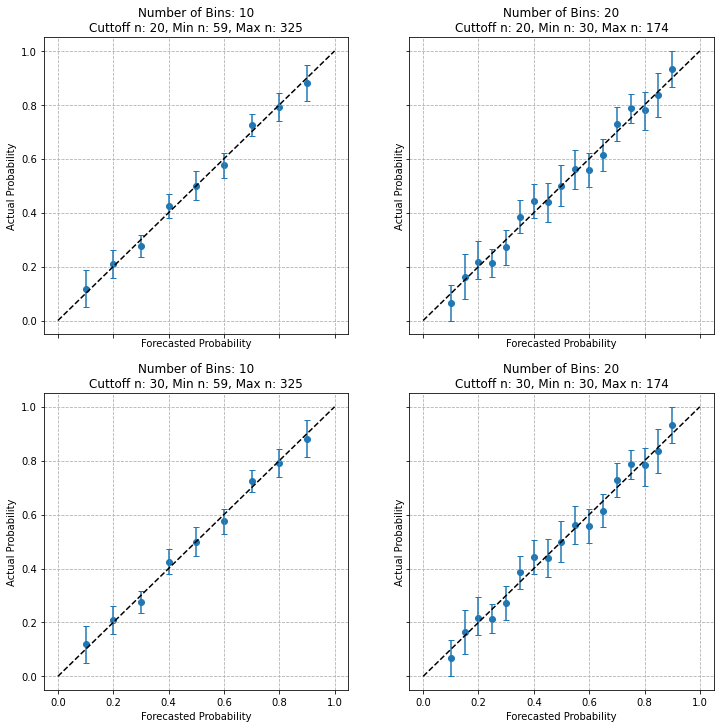

In [26]:
n_mins = [20, 30]
bins = [(0.05, 10), (0.025, 20)]  # (buffer to exclude on the edges, n_bins)
rows = len(n_mins)
cols = len(bins)

for_plts = []

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(12,12))
for i, x in enumerate(product(n_mins, bins)):
    # compute bins, create symmetrical dfs
    n_min, bns = x[0], x[1]
    step, b = bns[0], bns[1]
    ip = pd.DataFrame(odds['IP_Fav'].append(odds['IP_Dog']).reset_index(drop=True))
    ip['Fav_Winner'] = pd.DataFrame(odds['Fav_Winner'].append(odds['Fav_Winner'].apply(lambda x: flip_ones_w_nan(x))).reset_index(drop=True))
    ip['Bin_'+str(b)] = pd.DataFrame(pd.cut(ip[0], bins=np.linspace(step, 1.0-step, b)).apply(lambda x: x.right-step))  # (left, right]
    ip.set_index('Bin_'+str(b), inplace=True)
    
    # calculate statistics
    for_plt = pd.DataFrame(ip.groupby(by='Bin_'+str(b))['Fav_Winner'].sum() / ip.groupby(by='Bin_'+str(b))['Fav_Winner'].count())
    for_plt['n'] = ip.groupby(by='Bin_'+str(b))['Fav_Winner'].count()
    for_plt = for_plt.loc[for_plt['n'] >= n_min]
    
    # plot
    axs[i//cols][i%cols].set(title='Number of Bins: {}\nCuttoff n: {}, Min n: {}, Max n: {}'.format(b, n_min, for_plt['n'].min(), for_plt['n'].max()), xlabel='Forecasted Probability', ylabel='Actual Probability')
    axs[i//cols][i%cols].scatter(for_plt.index.values, for_plt.iloc[:, 0].values)
    errs = gen_ci_sizes(for_plt[['n', 'Fav_Winner']], alpha=0.1)  # gen CIs
    axs[i//cols][i%cols].errorbar(for_plt.index.values, for_plt.iloc[:, 0].values, errs, fmt='none', capsize=3)
    axs[i//cols][i%cols].plot(np.linspace(0.0, 1, 1000), np.linspace(0.0, 1, 1000), 'k--')
    axs[i//cols][i%cols].grid(b=True, which='major', linestyle='--')
    for_plts.append([n_min, b, for_plt])
plt.show()

## Initial Observations

- The Vegas implied probabilities seem pretty well calibrated and a useful tool for decision making (ie. survivor pool.) 
  - Still, they are not perfect and there's money to be made!
- As evidenced by the CIs, these values could vary +/- 5% or so based

Let's compare to FiveThirtyEight

Vegas 2017-2020

In [54]:
np.round(abs(np.round(for_plt['Fav_Winner'].values, 2) - np.round(for_plt.index.values, 2)).mean(), 4)

0.0259

FiveThirtyEight 2015-2020

In [55]:
fte_diff = [6, 2, 3, 6, 6, 2, 2, 1, 0, 1, 2, 2, 6, 6, 3, 2, 6]
np.round(sum(fte_diff)/len(fte_diff)/100, 4)

0.0329

# Comparing to FiveThirtyEight Models
https://projects.fivethirtyeight.com/checking-our-work/nfl-games/
- The average percent deviation (based on 10% to 90% buckets)
  - **FiveThirtyEight 2015-2018**: `0.0329`
  - **Vegas 2017-2020**: `0.0259`
- Overall, Vegas closing line is $0.7\%$ more efficient than FiveThirtyEight, reflecting the efficiency of betting markets
- For a more rigorous comparison, we could look at the Brier Score (effectively MSE of the predictions)

### Future Opportunities
- Look at Brier score (essentially MSE of forecasts)
  - https://en.wikipedia.org/wiki/Brier_score#3-component_decomposition
  - Can be decomposed into 3 parts
  - https://projects.fivethirtyeight.com/checking-our-work/march-madness-men/